## Libs

In [1]:
! pip install stringcase --user

You should consider upgrading via the 'd:\arquivos e programas\anaconda\python.exe -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import pandas as pd
import psycopg2
import json
import time
import uuid
import datetime
import re
import stringcase
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud

## Database

In [53]:
DB_NAME = 'templatedb'
DB_USER = 'template'
DB_HOST = 'ec2-18-190-52-149.us-east-2.compute.amazonaws.com'
DB_PORT = 5432
DB_TIME = 240
DB_PASS = 'templatedb'

today = datetime.datetime.now()
try:  # connect to postgres
    conn = psycopg2.connect(
        dbname=DB_NAME,
        user=DB_USER,
        host=DB_HOST,
        port=DB_PORT,
        password=DB_PASS,
        connect_timeout=DB_TIME
    )
    tm = time.time()
    print('Connected to database: [%s] @ %d seconds' %
                 (DB_HOST, time.time() - tm))
except Exception as e:
    print('Cannot connect to Postgres [%s]' % DB_HOST)
    print(str(e))
    exit(1)

Connected to database: [ec2-18-190-52-149.us-east-2.compute.amazonaws.com] @ 0 seconds


## Functions

In [5]:
char_colors = ['#FF7CB9','#979FEF']
csfont = {'fontname':'Helvetica'}

remove_special_char = lambda word: re.sub(r'[!.,\-";:~><^%$#@&*\(\)-+=_\'\?]','', word)

def calculate_age(birth): 
  age = today.year - birth.year - ((today.month, today.day) < (birth.month, birth.day)) 
  return age

def define_class(x):
  if x > 0.5:
    return 1
  elif x < 0.5:
    return 0
  else:
    return 0.5

def get_vocabulary(df):
  count_vectorizer = CountVectorizer(lowercase=False,stop_words=[])
  cv_fit = count_vectorizer.fit_transform(df['content'])
  word_list = count_vectorizer.get_feature_names()
  frequecy_array = cv_fit.toarray()
  count_list = frequecy_array.sum(axis=0)
  vocabulary = (dict(zip(word_list, count_list)))
  return vocabulary, frequecy_array, word_list

def normalize_dict(df):
  aux_df = dict({})
  for key in df.keys():
    aux_df[key] = np.round(df[key]/sum(df.values()),2)*100
  return aux_df

## Dataset Info

In [6]:
db_info = dict({})

### Users

In [7]:
try:
    users_df = pd.read_csv('data/users-df.csv')
except:
    print('Retrieving from original database...')
    users_df = pd.read_sql_query('select username, email, birth, gender from users;',conn)
    users_df['age'] = users_df['birth'].apply(calculate_age)
    users_df.to_csv('data/users-df.csv', index=False)

In [8]:
temp_users = dict({})
count_votes_by_gender = users_df.groupby(['gender'])['username'].count()
temp_users['total'] = count_votes_by_gender['fem']+count_votes_by_gender['masc']
temp_users['female'] = count_votes_by_gender['fem']
temp_users['male'] = count_votes_by_gender['masc']
db_info['users'] = temp_users

### Comments

In [9]:
try:
    labeled_comments = pd.read_csv('./data/labeled-comments.csv')
except:
    print('Retrieving from original database...')
    labeled_comments = pd.read_sql_query('select * from results;',conn)
    labeled_comments['label'] = labeled_comments['avg'].apply(lambda x: 1 if x > 0.5 else 0 if x < 0.5 else -1)
    labeled_comments['char-qty'] = labeled_comments['content'].apply(lambda comment: len(comment))
    labeled_comments['word-qty'] = labeled_comments['content'].apply(lambda comment: len(comment.lower().split(' ')))
    labeled_comments.to_csv('./data/labeled-comments.csv', index=False)

sexist_comments = labeled_comments[labeled_comments['avg'] > 0.5]
not_sexist_comments = labeled_comments[labeled_comments['avg'] < 0.5]
undefined_comments = labeled_comments[labeled_comments['avg'] == 0.5]

In [10]:
labeled_comments.head(5)

,comment_id,content,likes,dislikes,avg,label,char-qty,word-qty
0,790,Perfeito!,2.0,2.0,0.333333,0,9,1
1,2850,"Impressão sua, a diferença é que agora você vê...",4.0,0.0,0.500000,-1,270,44
2,1798,Rio de Janeiro é isso ai,8.0,7.0,0.000000,0,24,6
3,1489,MUITO MAIS LEGAL RRSRSRRSRSRS,2.0,0.0,0.000000,0,30,5
4,1269,Falem por vocês. Eu não tô nem aí para a mulhe...,1.0,2.0,1.000000,1,96,19


In [11]:
temp_comments = dict({})
count_comments = labeled_comments.groupby(['label'])['comment_id'].count()
temp_comments['total'] = labeled_comments.shape[0]
temp_comments['sexist'] = {
    'total_qty': count_comments[1],
    'likes_qty': sexist_comments.sum()['likes'],
    'dislikes_qty': sexist_comments.sum()['dislikes'],
    'likes_qty_median': sexist_comments.median()['likes'],
    'dislikes_qty_median': sexist_comments.median()['dislikes'],
    'char_qty_median': sexist_comments.median()['char-qty'],
    'word_qty_median': sexist_comments.median()['word-qty']
}
temp_comments['not_sexist'] = {
    'total_qty': count_comments[0],
    'likes_qty': not_sexist_comments.sum()['likes'],
    'dislikes_qty': not_sexist_comments.sum()['dislikes'],
    'likes_qty_median': not_sexist_comments.median()['likes'],
    'dislikes_qty_median': not_sexist_comments.median()['dislikes'],
    'char_qty_median': not_sexist_comments.median()['char-qty'],
    'word_qty_median': not_sexist_comments.median()['word-qty']
}
temp_comments['undefined'] = {
    'total_qty': count_comments[-1],
    'likes_qty': undefined_comments.sum()['likes'],
    'dislikes_qty': undefined_comments.sum()['dislikes'],
    'likes_qty_median': undefined_comments.median()['likes'],
    'dislikes_qty_median': undefined_comments.median()['dislikes'],
    'char_qty_median': undefined_comments.median()['char-qty'],
    'word_qty_median': undefined_comments.median()['word-qty']
}
db_info['comments'] = temp_comments

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
sexist_vocabulary, sexist_frequency_array, sexist_word_list = get_vocabulary(sexist_comments)
not_sexist_vocabulary, not_sexist_frequency_array, not_sexist_word_list = get_vocabulary(not_sexist_comments)
undefined_vocabulary, undefined_frequency_array, undefined_word_list = get_vocabulary(undefined_comments)

#### Shared words between sexist and not sexist comments

In [13]:
list_sexist_sorted_terms = []
for key, value in sorted(sexist_vocabulary.items(), key=lambda item: item[1]):
    list_sexist_sorted_terms.append(key)
list_sexist_sorted_terms.reverse()

shared_words = []

for word in list_sexist_sorted_terms:
    if word in not_sexist_vocabulary.keys():
        shared_words.append(word)

word_freq = {
    'word': [],
    'sexist-freq': [],
    'not-sexist-freq': [],
    'undefined-freq' : [],
    'diff' : []
}

for word in shared_words:
    word_freq['word'].append(word)
    if word in sexist_vocabulary.keys():
      word_freq['sexist-freq'].append(sexist_vocabulary[word])
    else:
      word_freq['sexist-freq'].append(0)
    if word in sexist_vocabulary.keys():
      word_freq['not-sexist-freq'].append(not_sexist_vocabulary[word])
    else:
      word_freq['not-sexist-freq'].append(0)
    if word in undefined_vocabulary.keys():
        word_freq['undefined-freq'].append(undefined_vocabulary[word])
    else:
        word_freq['undefined-freq'].append(0)
    word_freq['diff'] = sexist_vocabulary[word] - not_sexist_vocabulary[word]

word_freq = pd.DataFrame(word_freq)

# normalizind frequencies
sum_sexist = sum(word_freq['sexist-freq'])
word_freq['sexist-freq'] = word_freq['sexist-freq'].apply(lambda x: x/sum_sexist)
sum_not_sexist = sum(word_freq['not-sexist-freq'])
word_freq['not-sexist-freq'] = word_freq['not-sexist-freq'].apply(lambda x: x/sum_not_sexist)
undefined_sexist = sum(word_freq['undefined-freq'])
word_freq['undefined-freq'] = word_freq['undefined-freq'].apply(lambda x: x/undefined_sexist)
word_freq['diff'] = word_freq['sexist-freq'] - word_freq['not-sexist-freq']

sexist_words = word_freq[word_freq['diff'] > 0]
not_sexist_words = word_freq[word_freq['diff'] < 0]

In [14]:
not_sexist_words

,word,sexist-freq,not-sexist-freq,undefined-freq,diff
0,que,0.044495,0.046601,0.056109,-0.002106
2,não,0.021923,0.024332,0.029167,-0.002409
10,para,0.009743,0.010361,0.008902,-0.000618
12,da,0.009094,0.009423,0.010777,-0.000329
13,por,0.008850,0.009142,0.008551,-0.000292
...,...,...,...,...,...
3002,18,0.000041,0.000094,0.000234,-0.000053
3003,16,0.000041,0.000141,0.000117,-0.000100
3004,15,0.000041,0.000094,0.000351,-0.000053
3005,11,0.000041,0.000047,0.000117,-0.000006


In [15]:
relevant_sexist_words = list(sexist_words.sort_values(by=['diff'], ascending=False)['word'])

# 20 most relevant words to sexist comments
top20_sexist_words = sexist_words.sort_values(by ='diff',ascending=False ).head(20)
top20_sexist_words['perc_S'] = top20_sexist_words['sexist-freq'].apply(lambda x : x)
top20_sexist_words

,word,sexist-freq,not-sexist-freq,undefined-freq,diff,perc_S
1,de,0.043642,0.036990,0.041115,0.006652,0.043642
9,mulheres,0.010109,0.006892,0.011128,0.003217,0.010109
19,homens,0.006739,0.004079,0.008434,0.002660,0.006739
18,ela,0.007592,0.005063,0.005857,0.002528,0.007592
8,mulher,0.011246,0.008767,0.008902,0.002479,0.011246
47,feia,0.002639,0.000234,0.001523,0.002404,0.002639
48,assédio,0.002639,0.000891,0.001991,0.001748,0.002639
11,as,0.009459,0.007736,0.007848,0.001724,0.009459
16,na,0.008079,0.006376,0.008317,0.001703,0.008079
25,homem,0.005684,0.004079,0.004803,0.001605,0.005684


In [16]:
# print table to latex
for i, r in top20_sexist_words.iterrows():
    print("{%s} & {%0.6f} & {%0.6f} & {%0.6f}\\\\" %
          (r['word'], r['sexist-freq'], r['not-sexist-freq'], r['diff']))

{de} & {0.043642} & {0.036990} & {0.006652}\\
{mulheres} & {0.010109} & {0.006892} & {0.003217}\\
{homens} & {0.006739} & {0.004079} & {0.002660}\\
{ela} & {0.007592} & {0.005063} & {0.002528}\\
{mulher} & {0.011246} & {0.008767} & {0.002479}\\
{feia} & {0.002639} & {0.000234} & {0.002404}\\
{assédio} & {0.002639} & {0.000891} & {0.001748}\\
{as} & {0.009459} & {0.007736} & {0.001724}\\
{na} & {0.008079} & {0.006376} & {0.001703}\\
{homem} & {0.005684} & {0.004079} & {0.001605}\\
{elas} & {0.002273} & {0.000703} & {0.001570}\\
{feminismo} & {0.002720} & {0.001172} & {0.001548}\\
{feministas} & {0.002030} & {0.000563} & {0.001467}\\
{uma} & {0.011733} & {0.010267} & {0.001465}\\
{feminista} & {0.001908} & {0.000563} & {0.001345}\\
{com} & {0.012057} & {0.010830} & {0.001228}\\
{querem} & {0.001949} & {0.000750} & {0.001199}\\
{essa} & {0.004100} & {0.002907} & {0.001194}\\
{só} & {0.005359} & {0.004266} & {0.001093}\\
{Essa} & {0.002030} & {0.000985} & {0.001045}\\


### Histograms

In [17]:
hiss = word_freq[word_freq['diff']>0].sort_values(by=['diff'], ascending=False)
hisn = word_freq[word_freq['diff']<0].sort_values(by=['diff'], ascending=True)
HS = list(hiss['sexist-freq'])
HN = list(hisn['not-sexist-freq'])

remove_special_char = lambda word: re.sub(r'[!.,\-";:~><^%$#@&*\(\)-+=_\'\?]','', word)
words = list(word_freq['word'])

duno_comments = [c for c in list(undefined_comments['content'])]
duno_matriz = []
words = list(hiss['word'])
for comment in duno_comments:
    hist = []
    for word in words:
        f = comment.split(' ').count(word)
        hist.append(f)
#     hist = [x/sum(hist) if sum(hist) > 0 else 0 for x in hist]
    duno_matriz.append(hist)
from scipy.spatial import distance
JSD_S = []
for line in duno_matriz:
    dist = distance.jensenshannon(HS, line)
    JSD_S.append(dist)

duno_matriz = []
words = list(hisn['word'])
for comment in duno_comments:
    hist = []
    for word in words:
        f = comment.split(' ').count(word)
        hist.append(f)
#     hist = [x/sum(hist) if sum(hist) > 0 else 0 for x in hist]
    duno_matriz.append(hist)
from scipy.spatial import distance
JSD_N = []
for line in duno_matriz:
    dist = distance.jensenshannon(HN, line)
    JSD_N.append(dist)

D:\Arquivos e Programas\Anaconda\lib\site-packages\scipy\spatial\distance.py:1289: RuntimeWarning: invalid value encountered in true_divide
  q = q / np.sum(q, axis=0)


In [73]:
db_info

{'users': {'total': 252, 'female': 143, 'male': 109},
 'comments': {'total': 3172,
  'sexist': {'total_qty': 1397,
   'likes_qty': 27610.0,
   'dislikes_qty': 21842.0,
   'likes_qty_median': 8.0,
   'dislikes_qty_median': 3.0,
   'char_qty_median': 97.0,
   'word_qty_median': 17.0},
  'not_sexist': {'total_qty': 1275,
   'likes_qty': 20528.0,
   'dislikes_qty': 8971.0,
   'likes_qty_median': 6.0,
   'dislikes_qty_median': 1.0,
   'char_qty_median': 88.0,
   'word_qty_median': 16.0},
  'undefined': {'total_qty': 500,
   'likes_qty': 6630.0,
   'dislikes_qty': 4411.0,
   'likes_qty_median': 5.0,
   'dislikes_qty_median': 1.5,
   'char_qty_median': 78.0,
   'word_qty_median': 14.0}}}

In [18]:
a= pd.DataFrame(JSD_S)
a = a.fillna(0)
group_values_S = {
    '<0.6': len(a[a[0]<0.6]),
    '0.6 < x < 0.7': len(a[(a[0]>=0.6) & (a[0]<0.7)]),
    '0.7 < x < 0.8': len(a[(a[0]>=0.7) & (a[0]<0.8)]),
    '0.8 < x < 0.9': len(a[(a[0]>=0.8) & (a[0]<0.9)]),
    '0.9 < x < 1': len(a[(a[0]>=0.9) & (a[0]<1)]),
    '> 1': len(a[(a[0]>=1)])
}

In [19]:
b = pd.DataFrame(JSD_N)
b = b.fillna(0)
group_values_NS = {
    '<0.6': len(b[b[0]<0.6]),
    '0.6 < x < 0.7': len(b[(b[0]>=0.6) & (b[0]<0.7)]),
    '0.7 < x < 0.8': len(b[(b[0]>=0.7) & (b[0]<0.8)]),
    '0.8 < x < 0.9': len(b[(b[0]>=0.8) & (b[0]<0.9)]),
    '0.9 < x < 1': len(b[(b[0]>=0.9) & (b[0]<1)]),
    '> 1': len(b[(b[0]>=1)])
}

In [20]:
data = pd.DataFrame({ 'Comentários não sexistas': JSD_N, 'Comentários sexistas': JSD_S})

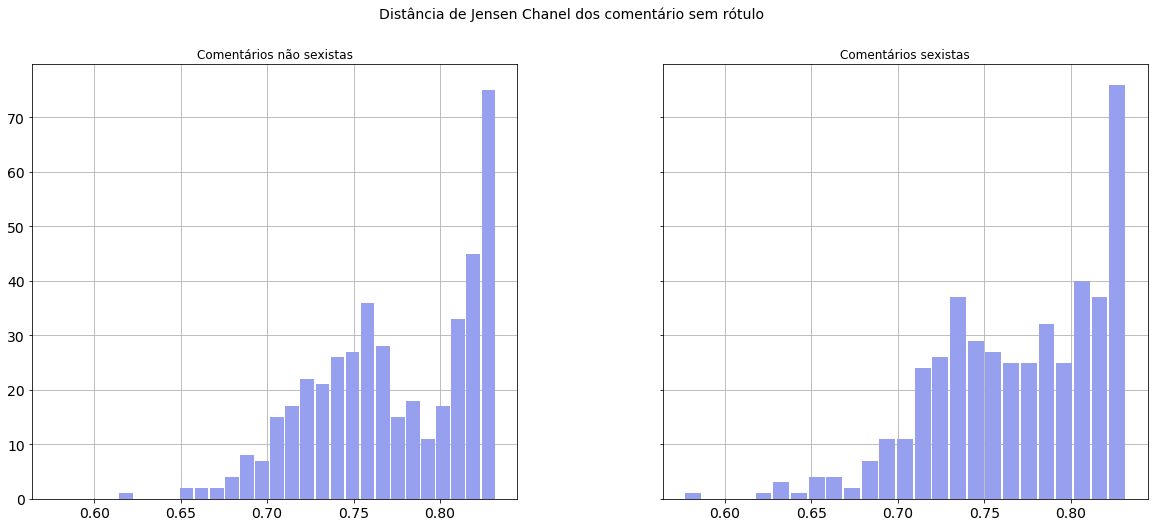

In [21]:
axes = data.hist(sharey=True,
                 sharex=True,
                 bins=25,
                 grid=True,
                 figsize=(20,8),
                 color=char_colors[1],
                 zorder=2,
                 ylabelsize=14,
                 xlabelsize=14,
                 rwidth=0.9)
plt.suptitle("Distância de Jensen Chanel dos comentário sem rótulo", fontsize=14)
plt.savefig('./images/jsd_distances.png',
         orientation='landscape',
         format='png',
         bbox_inches='tight')

## Votes

In [22]:
try:
    votes_per_user = pd.read_csv('data/votes-per-user.csv')
except:
    print('Retrieving from original database...')
    votes_per_user = pd.read_sql_query('''
    with q as (
        select v.vote_id,
           c.comment_id,
           v.user_id,
           v.gender,
           date_part('year',age(v.birth)) as age,
           c.content,
           v.vote,
           v.avg as label
    from comments c
             join (select v1.comment_id,
                          r.avg,
                          v1.vote_id,
                          v1.serial_id as user_id,
                          v1.user_id as id,
                          v1.vote,
                          v1.gender,
                          v1.birth
                   from (
                        select u.serial_id,v2.vote,v2.vote_id, u.gender,v2.comment_id, u.birth, v2.user_id
                        from votes v2 join ( select ROW_NUMBER() OVER(ORDER BY (SELECT 1)) AS serial_id,* from users) u on v2.user_id = u.username
                       ) v1 join results r on v1.comment_id = r.comment_id) v on c.comment_id = v.comment_id
    )
    select * from q;
    ''', conn)
    votes_per_user.to_csv('data/votes-per-user.csv', index=False)

In [23]:
votes_per_user.head(5)

,vote_id,comment_id,user_id,gender,age,content,vote,label
0,5972,790,1,fem,22.0,Perfeito!,0,0.333333
1,1652,790,58,masc,22.0,Perfeito!,0,0.333333
2,754,790,16,fem,20.0,Perfeito!,1,0.333333
3,4298,2850,155,masc,31.0,"Impressão sua, a diferença é que agora você vê...",0,0.500000
4,1086,2850,26,masc,23.0,"Impressão sua, a diferença é que agora você vê...",1,0.500000


In [84]:
a = votes_per_user.groupby(by='comment_id').count()
a.groupby(by='vote_id').count()['vote']

vote_id
1     419
2    1581
3    1168
4       1
Name: vote, dtype: int64

In [87]:
votes_per_user.groupby(by='gender').count()['user_id']

gender
fem     4764
masc    2325
Name: user_id, dtype: int64

In [54]:
x = pd.read_sql_query('select count(qtd), qtd from (select count(vote_id) as qtd from votes group by user_id) as u group by qtd;', conn)

In [55]:
x = x.loc[:, ~x.columns.str.contains('^Unnamed')]

In [61]:
x = x.set_index('qtd')

In [65]:
x =x.sort_index()

In [69]:
b = x.index.values

In [70]:
c = x['count'].values

In [36]:
np.mean(list(x['qtd']))

61.0

In [37]:
np.min(list(x['qtd']))

1

In [38]:
np.max(list(x['qtd']))

676

In [40]:
x[x['qtd'] == 1]

,count,qtd
66,11,1


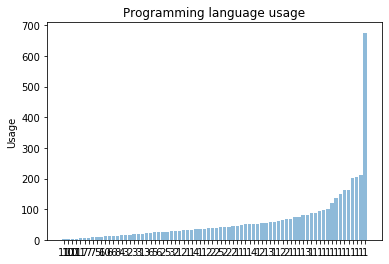

In [72]:
objects = c
y_pos = np.arange(len(objects))
performance = b 

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')

plt.show()

**Confusion Matrix to Manual Classifications**

In [26]:
from sklearn.metrics import confusion_matrix

def matriz_confusao(gender,df):
  df = df[(votes_per_user['gender']==gender) & (votes_per_user['label']!=0.5)]
  y_true = [float(x) for x in list(df['label'].apply(define_class))]
  y_pred = [float(x) for x in list(df['vote'].apply(define_class))]
  return pd.DataFrame(confusion_matrix(y_true, y_pred, labels=[1,0]), columns=['Sr','Nr'], index=['Sv','Nv'])

female_confussion_matrix = matriz_confusao('fem',votes_per_user)
male_confussion_matrix = matriz_confusao('masc',votes_per_user)

In [27]:
female_confussion_matrix

,Sr,Nr
Sv,2039,182
Nv,168,1702


In [28]:
male_confussion_matrix

,Sr,Nr
Sv,911,102
Nv,118,868


In [29]:
def precision_recal_f1(matrix):
  tp = matrix['Sr']['Sv']
  tp_fn = tp + matrix['Sr']['Nv']
  tp_fp = tp + matrix['Nr']['Sv']
  precision = tp/tp_fp
  recall = tp/tp_fn
  f1 = 2 * (precision * recall) / (precision + recall)
  return precision, recall, f1

precision_fem, recall_fem, f1_fem = precision_recal_f1(female_confussion_matrix)
precision_male, recall_male, f1_male = precision_recal_f1(male_confussion_matrix)

In [30]:
print(f'Female metrics: {precision_fem, recall_fem, f1_fem}')
print(f'Male metrics: {precision_male, recall_male, f1_male}')

Female metrics: (0.9180549302116164, 0.923878568192116, 0.9209575429087623)
Male metrics: (0.8993089832181639, 0.8853255587949466, 0.8922624877571009)


**Calculating vote info by gender/age**

In [31]:
age_list = list(votes_per_user.age.unique())
age_list.sort()

qtd_votes_per_age = dict({})

qtd_female_votes_per_age = dict({})
qtd_sexist_female_votes_per_age = dict({})
qtd_not_sexist_female_votes_per_age = dict({})

qtd_correct_sexist_female_votes_per_age = dict({})
qtd_correct_not_sexist_female_votes_per_age = dict({})
qtd_incorrect_sexist_female_votes_per_age = dict({})
qtd_incorrect_not_sexist_female_votes_per_age = dict({})

qtd_male_votes_per_age = dict({})
qtd_sexist_male_votes_per_age = dict({})
qtd_not_sexist_male_votes_per_age = dict({})

qtd_correct_sexist_male_votes_per_age = dict({})
qtd_correct_not_sexist_male_votes_per_age = dict({})
qtd_incorrect_sexist_male_votes_per_age = dict({})
qtd_incorrect_not_sexist_male_votes_per_age = dict({})

for age in age_list:
  qtd_votes_per_age[age] = votes_per_user[votes_per_user['age']==age].shape[0]
for age in age_list:
  qtd_female_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='fem')].shape[0]
for age in age_list:
  qtd_male_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='masc')].shape[0]

for age in age_list:
  qtd_sexist_female_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='fem') & (votes_per_user['vote']==1)].shape[0]
for age in age_list:
  qtd_not_sexist_female_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='fem') & (votes_per_user['vote']==0)].shape[0]

for age in age_list:
  qtd_sexist_male_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='masc') & (votes_per_user['vote']==1)].shape[0]
for age in age_list:
  qtd_not_sexist_male_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='masc') & (votes_per_user['vote']==0)].shape[0]

for age in age_list:
  qtd_correct_sexist_female_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='fem') & (votes_per_user['vote']==1) & (votes_per_user['label']>0.5)].shape[0]
for age in age_list:
  qtd_correct_not_sexist_female_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='fem') & (votes_per_user['vote']==0) & (votes_per_user['label']<0.5)].shape[0]
for age in age_list:
  qtd_incorrect_sexist_female_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='fem') & (votes_per_user['vote']==0) & (votes_per_user['label']>0.5)].shape[0]
for age in age_list:
  qtd_incorrect_not_sexist_female_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='fem') & (votes_per_user['vote']==1) & (votes_per_user['label']<0.5)].shape[0]

for age in age_list:
  qtd_correct_sexist_male_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='masc') & (votes_per_user['vote']==1) & (votes_per_user['label']>0.5)].shape[0]
for age in age_list:
  qtd_correct_not_sexist_male_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='masc') & (votes_per_user['vote']==0) & (votes_per_user['label']<0.5)].shape[0]
for age in age_list:
  qtd_incorrect_sexist_male_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='masc') & (votes_per_user['vote']==0) & (votes_per_user['label']>0.5)].shape[0]
for age in age_list:
  qtd_incorrect_not_sexist_male_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='masc') & (votes_per_user['vote']==1) & (votes_per_user['label']<0.5)].shape[0]

## Charts

In [32]:
def plot_pizza(title, labels, values):
  fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
  recipe = labels
  data = values
  def func(pct, allvals):
      absolute = int(pct/100.*np.sum(allvals))
      return "{:.1f}%\n({:d})".format(pct, absolute)

  wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                    textprops=dict(color="w"), colors=char_colors)

  lgd = ax.legend(wedges, recipe,
            title="Classes",
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1))
  plt.tight_layout()
  plt.title(title,**csfont)
  plt.setp(autotexts, size=15, weight="bold")
  plt.savefig(f'./images/{stringcase.snakecase(title)}.png',
             orientation='landscape',
             format='png',
             bbox_extra_artists=(lgd,),
             bbox_inches='tight')

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


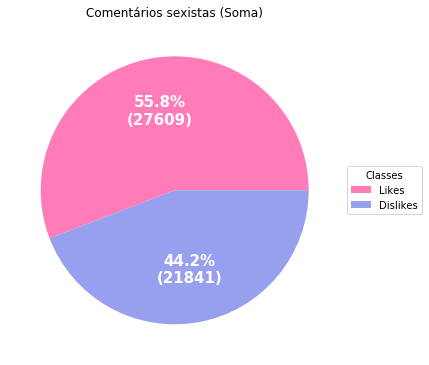

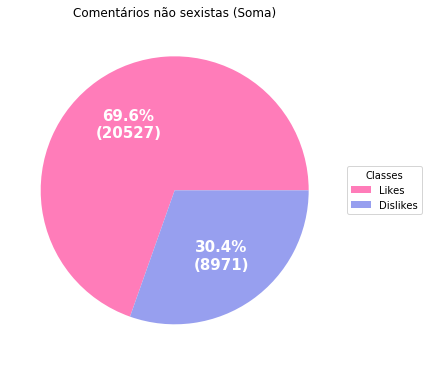

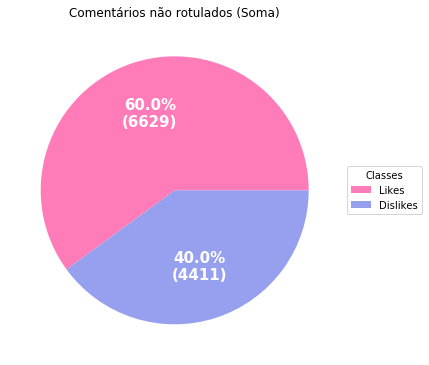

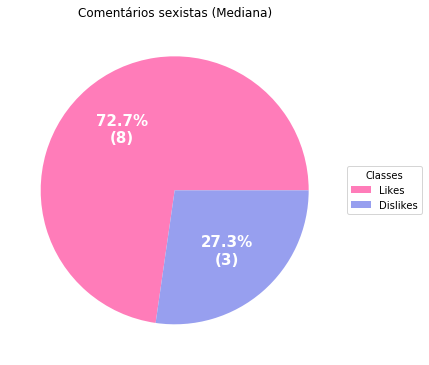

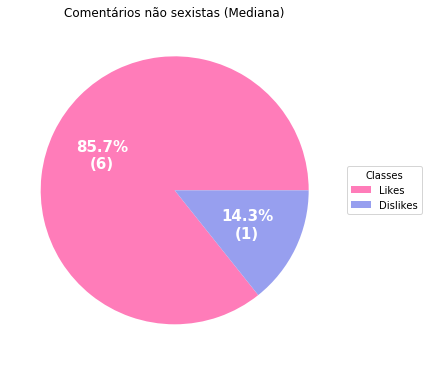

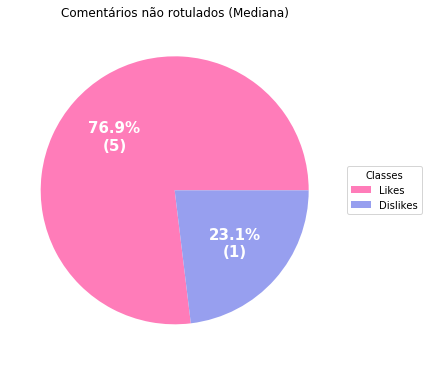

In [33]:
plot_pizza('Comentários sexistas (Soma)',
           ['Likes','Dislikes'],
           [temp_comments.get('sexist').get('likes_qty'),
            temp_comments.get('sexist').get('dislikes_qty')],
          )
plot_pizza('Comentários não sexistas (Soma)',
           ['Likes','Dislikes'],
           [temp_comments.get('not_sexist').get('likes_qty'),
            temp_comments.get('not_sexist').get('dislikes_qty')]
          )
plot_pizza('Comentários não rotulados (Soma)',
           ['Likes','Dislikes'],
           [temp_comments.get('undefined').get('likes_qty'),
            temp_comments.get('undefined').get('dislikes_qty')]
          )
plot_pizza('Comentários sexistas (Mediana)',
           ['Likes','Dislikes'],
           [temp_comments.get('sexist').get('likes_qty_median'),
            temp_comments.get('sexist').get('dislikes_qty_median')]
          )
plot_pizza('Comentários não sexistas (Mediana)',
           ['Likes','Dislikes'],
           [temp_comments.get('not_sexist').get('likes_qty_median'),
            temp_comments.get('not_sexist').get('dislikes_qty_median')]

          )
plot_pizza('Comentários não rotulados (Mediana)',
           ['Likes','Dislikes'],
           [temp_comments.get('undefined').get('likes_qty_median'),
            temp_comments.get('undefined').get('dislikes_qty_median')]
          )

In [34]:
def doublebar_plot(df_1, df_2, ages, title):
  X = np.array(ages)
  Y1 = np.array(list((df_1).values()))
  Y2 = np.array(list((df_2).values()))

  fig, ax = plt.subplots(figsize=(20,8))

  ax.axhline(0, color='black', lw=1)

  ax.bar(X, +Y1, facecolor=char_colors[0], edgecolor='white', label='Homens', width=1)
  ax.bar(X, -Y2, facecolor=char_colors[1], edgecolor='white', label='Mulheres', width=1)

  lgd = ax.legend(fontsize = 13)

  for x,y in zip(X,Y1):
      ax.text(x, y, '%d%%' % y, ha='center', va= 'bottom', fontsize = 14)
  for x,y in zip(X,Y2):
      ax.text(x, -y-0.01, '%d%%' % y, ha='center', va= 'top', fontsize = 14)

  plt.xlabel("Idades")
  plt.ylabel("Porcentagem de votos atribuídos")
  plt.xticks(X)
  plt.savefig(f'./images/{stringcase.snakecase(title)}.png',
             orientation='landscape',
             format='png',
             bbox_extra_artists=(lgd,),
             bbox_inches='tight')
  plt.show()

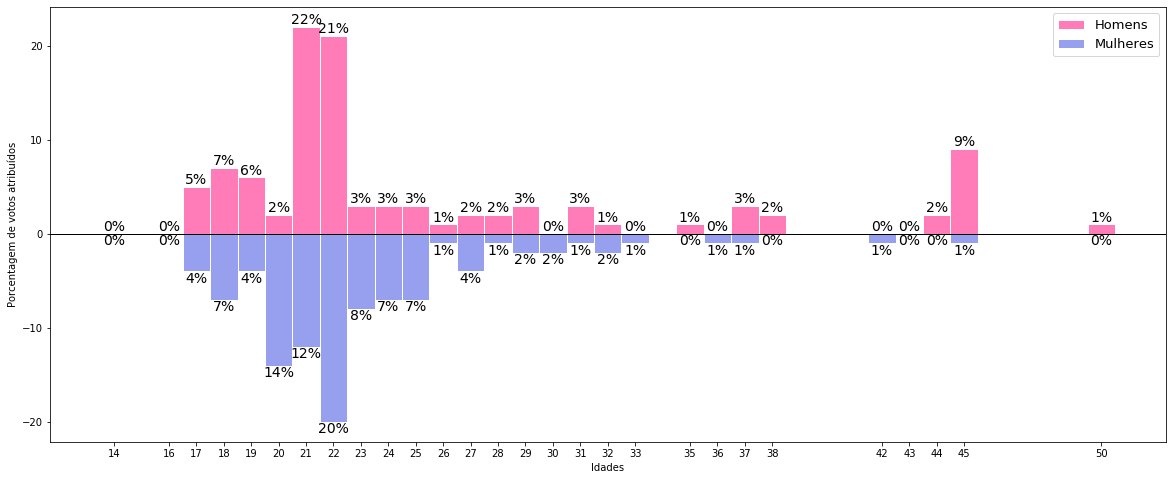

In [35]:
# corretos-sexista-genero-idade
doublebar_plot(normalize_dict(qtd_correct_sexist_male_votes_per_age),
               normalize_dict(qtd_correct_sexist_female_votes_per_age),
               age_list,
               title='corretos-sexista-genero-idade'
              )

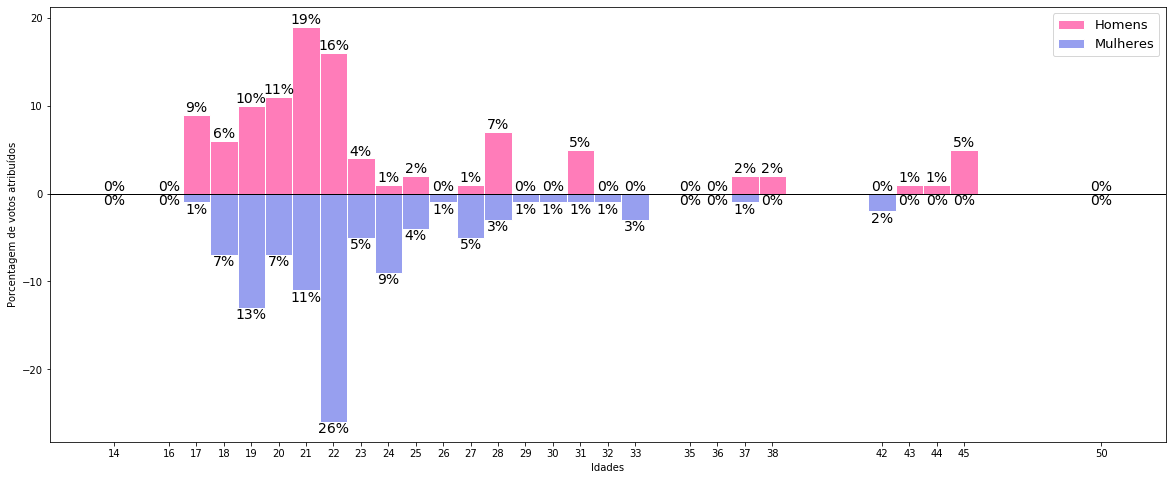

In [36]:
# incorretos-sexista-genero-idade
doublebar_plot(normalize_dict(qtd_incorrect_sexist_male_votes_per_age),
               normalize_dict(qtd_incorrect_sexist_female_votes_per_age),
               age_list,
               title='incorretos-sexista-genero-idade'
              )

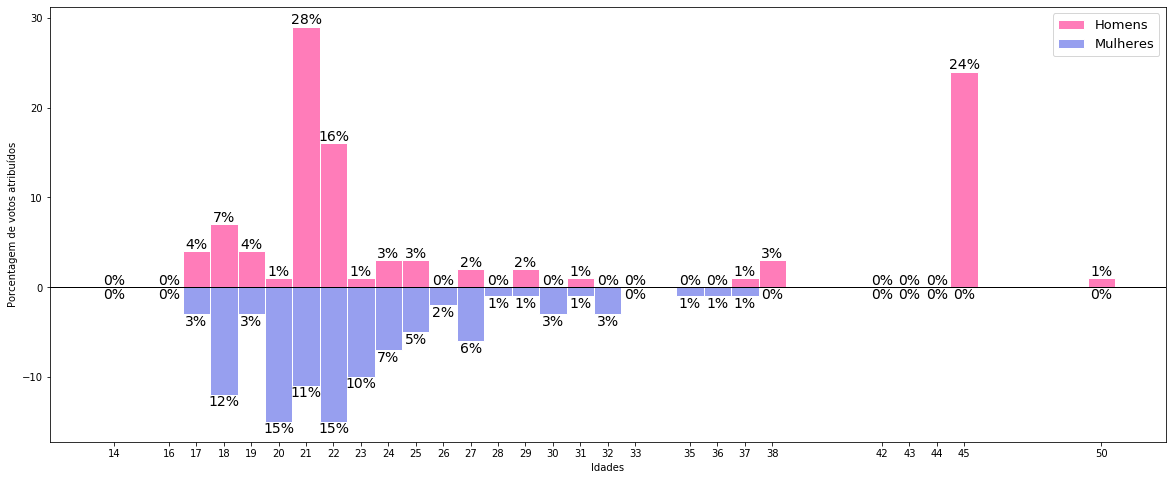

In [37]:
# incorretos-nao-sexista-genero-idade
doublebar_plot(normalize_dict(qtd_incorrect_not_sexist_male_votes_per_age),
               normalize_dict(qtd_incorrect_not_sexist_female_votes_per_age),
               age_list,
               title='incorretos-nao-sexista-genero-idade'
              )

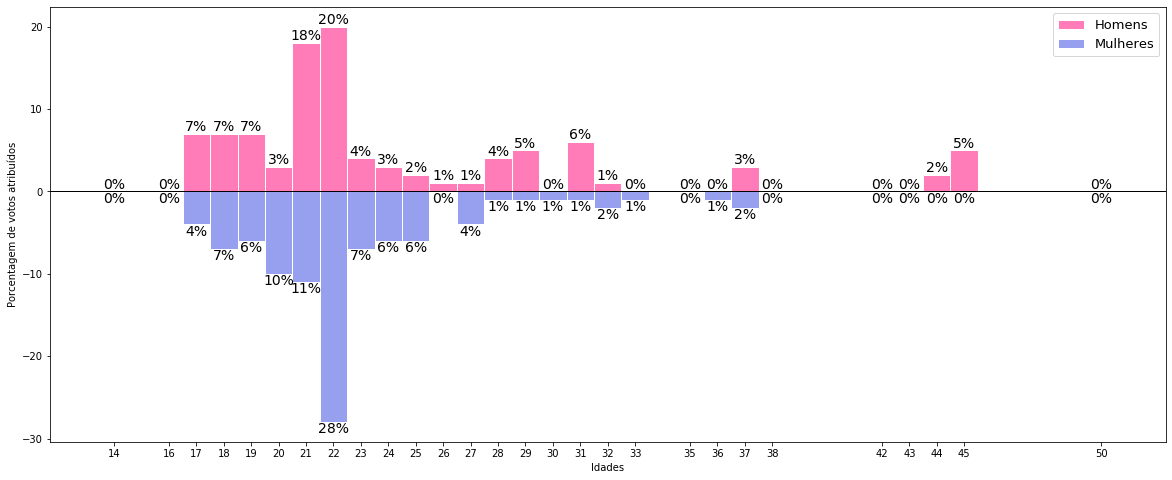

In [38]:
# corretos-nao-sexista-genero-idade
doublebar_plot(normalize_dict(qtd_correct_not_sexist_male_votes_per_age),
               normalize_dict(qtd_correct_not_sexist_female_votes_per_age),
               age_list,
               title='corretos-nao-sexista-genero-idade'
              )

## Classificação Automática

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_relevant_sexist_words = relevant_sexist_words

sexist_vectorizer = TfidfVectorizer(
    stop_words=[],
    use_idf=False,
    norm=None,
    decode_error='replace',
    max_features=100,
)
not_sexist_vectorizer = TfidfVectorizer(
    stop_words=[],
    use_idf=False,
    decode_error='replace',
    max_features=100,
)
undefined_vectorizer = TfidfVectorizer(
    stop_words=[],
    use_idf=False,
    decode_error='replace',
    max_features=100,
)

sexist_doc = sexist_comments['content'].apply(lambda y: ' '.join([x for x in y.split() if x in tf_relevant_sexist_words]))
not_sexist_doc = not_sexist_comments['content'].apply(lambda y: ' '.join([x for x in y.split() if x in tf_relevant_sexist_words]))
undefined_doc = undefined_comments['content'].apply(lambda y: ' '.join([x for x in y.split() if x in tf_relevant_sexist_words]))

sexist_tf = pd.DataFrame(sexist_vectorizer.fit_transform(sexist_doc).toarray())
not_sexist_tf = pd.DataFrame(not_sexist_vectorizer.fit_transform(not_sexist_doc).toarray())
undefined_tf = pd.DataFrame(undefined_vectorizer.fit_transform(undefined_doc).toarray())

likes_df = np.array(pd.concat([sexist_comments['likes'], not_sexist_comments['likes']]).fillna(0))
dislikes_df = np.array(pd.concat([sexist_comments['dislikes'], not_sexist_comments['dislikes']]).fillna(0))
char_qty_df = np.array(pd.concat([sexist_comments['char-qty'], not_sexist_comments['char-qty']]).fillna(0))
word_qty_df = np.array(pd.concat([sexist_comments['word-qty'], not_sexist_comments['word-qty']]).fillna(0))

sexist_y = sexist_comments['avg'].apply(lambda x: 1)
not_sexist_y = not_sexist_comments['avg'].apply(lambda x: 0)
undefined_y = undefined_comments['avg'].apply(lambda x: -1)

y_df = np.array(pd.concat([sexist_y, not_sexist_y]))

tf_dataframe = pd.concat([sexist_tf, not_sexist_tf]).fillna(0)
tf_dataframe.to_csv('./data/tf_dataframe.csv', index=False)

### **Grid Search**

In [41]:
import pickle
from sklearn import svm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

In [42]:
def select_features(dataframe, sub):
    X_df = dataframe[dataframe.columns[:dataframe.shape[1] -sub -1]]
    M = np.concatenate([X_df],axis=1)
    X = pd.DataFrame(M)
    return X

In [119]:
def grid_search(file_path, method, params, method_name, X_, y, reload=False):
    tm = time.time()

    if reload:
        print('Executing Grid Search to %s.' % method_name)
        model = GridSearchCV(method, param_grid=params, cv=cv, n_jobs=8)
        model.fit(X_, y)
        pickle.dump(model, open(file_path, 'wb'))
    else:
        try:
            print('Reading %s. Model' % method_name)
            model = pickle.load(open(file_path, 'rb'))
        except:
            print('Executing Grid Search to %s.' % method_name)
            model = GridSearchCV(method, param_grid=params, cv=cv, n_jobs=8)
            model.fit(X_, y)
            pickle.dump(model, open(file_path, 'wb'))

    print('Model loaded in: @ %d seconds' %
                     ( time.time() - tm))
    print("The best parameters are %s with a score of %0.2f" % (model.best_params_, model.best_score_))
    print('-------------------------------------------------------------------------------------------')
    return model

In [159]:
try: 
    print('...')
    dataframe = pd.read_csv('./data/dataframe.csv')
except:
    print('---')
    dataframe = tf_dataframe
    dataframe['likes'] = likes_df
    dataframe['dislikes'] = dislikes_df
    dataframe['char-qty'] = char_qty_df
    dataframe['word-qty'] = word_qty_df
    dataframe['sexist'] = y_df
    dataframe = dataframe.fillna(0)
    dataframe = tf_dataframe.sample(frac=1)
    dataframe.to_csv('.data/dataframe.csv', index=False)

...


In [102]:
y_df = dataframe['sexist']
y = y_df.astype(int)
X = select_features(dataframe, 0)

In [103]:
select_features(dataframe, 2)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,2.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.57735,0.0,0.000000,0.0,0.0,0.0,0.0,3.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.00000,1.0,0.000000,0.0,0.0,0.0,0.0,8.0,4.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.00000,2.0,0.000000,0.0,0.0,0.0,0.0,3.0,1.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.00000,1.0,0.000000,0.0,0.0,0.0,0.0,12.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,1.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,10.0,6.0
2668,0.0,0.447214,0.0,0.0,0.0,0.0,0.447214,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.447214,0.0,0.0,0.0,0.0,12.0,3.0
2669,0.0,0.000000,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,9.0
2670,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,8.0,2.0


In [123]:
X_tf = select_features(dataframe, 4)
X_tf_ld = select_features(dataframe, 2)
X_tf_ld_wc = select_features(dataframe, 0)

**Support Vector Machine**

In [124]:
cv

StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None)

In [125]:
# svm_params = dict(gamma=[0.1,1,10], C=[0.1, 1,10])
svm_params = dict(gamma=np.logspace(-9, 3, 5), C=np.logspace(-2, 10, 5))

In [128]:
svm_tf = grid_search(
    './data/svm-tf-grid-search-model',
    SVC(),
    svm_params,
    'SVM with TF',
    X_tf, y,
    # reload=True
)

Reading SVM with TF. Model
Model loaded in: @ 0 seconds
The best parameters are {'C': 10.0, 'gamma': 1.0} with a score of 0.90
-------------------------------------------------------------------------------------------


In [129]:
svm_tf_ld = grid_search(
    './data/svm-tf-ld-grid-search-model',
    SVC(),
    svm_params,
    'SVM with TF, likes and dislikes',
    X_tf_ld, y,
)

Reading SVM with TF, likes and dislikes. Model
Model loaded in: @ 0 seconds
The best parameters are {'C': 10000000.0, 'gamma': 1e-06} with a score of 0.87
-------------------------------------------------------------------------------------------


In [130]:
svm_tf_ld_wc = grid_search(
    './data/svm-tf-ld-wc-grid-search-model',
    SVC(),
    svm_params,
    'SVM with TF, likes, dislikes and words&chars quantity',
    X_tf_ld_wc, y,            
)

Reading SVM with TF, likes, dislikes and words&chars quantity. Model
Model loaded in: @ 0 seconds
The best parameters are {'C': 10000000.0, 'gamma': 1e-06} with a score of 0.87
-------------------------------------------------------------------------------------------


**K-Nearest Neighbors**

In [132]:
knn_params = dict(n_neighbors=[3, 5, 11, 19], weights=['uniform', 'distance'], metric=['euclidean', 'manhattan'])

In [136]:
knn_tf = grid_search(
    './data/knn-tf-grid-search-model',
    KNeighborsClassifier(),
    knn_params,
    'KNN with TF',
    X_tf, y,
    # reload=True
)

Reading KNN with TF. Model
Model loaded in: @ 0 seconds
The best parameters are {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'} with a score of 0.84
-------------------------------------------------------------------------------------------


In [139]:
knn_tf_ld = grid_search(
    './data/knn-tf-ld-grid-search-model',
    KNeighborsClassifier(),
    knn_params,
    'KNN with TF, likes and dislikes',
    X_tf_ld, y,
    # reload=True
)


Reading KNN with TF, likes and dislikes. Model
Model loaded in: @ 0 seconds
The best parameters are {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'} with a score of 0.67
-------------------------------------------------------------------------------------------


In [140]:
knn_tf_ld_wc = grid_search(
    './data/knn-tf-ld-wc-grid-search-model',
    KNeighborsClassifier(),
    knn_params,
    'KNN with TF, likes, dislikes words and chars qauntitys',
    X_tf_ld_wc, y,
    reload=True
)

Executing Grid Search to KNN with TF, likes, dislikes words and chars qauntitys.
Model loaded in: @ 3 seconds
The best parameters are {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'uniform'} with a score of 0.60
-------------------------------------------------------------------------------------------


**Classification reports to single test**

In [142]:
from sklearn.model_selection import train_test_split
# Only TF
X1_train, X1_test, y1_train, y1_test = train_test_split(X_tf, y, stratify=y)
# TF, Likes and Dislikes
X2_train, X2_test, y2_train, y2_test = train_test_split(X_tf_ld, y, stratify=y)
# TF, Likes, Dislikes, Words and Chars quantities
X3_train, X3_test, y3_train, y3_test = train_test_split(X_tf_ld_wc, y, stratify=y)

In [143]:
from sklearn.metrics import classification_report

def report_results(X_test, y_test, model):
    y_ = model.predict(X_test)
    report = classification_report( y_test, y_ )
    c_matrix = confusion_matrix(y_test, y_,  labels=[1,0])
    return report, c_matrix

In [153]:
svm_tf_report, svm_tf_cmatrix = report_results(X1_test, y1_test, svm_tf)
svm_tf_ld_report, svm_tf_ld_cmatrix = report_results(X2_test, y2_test, svm_tf_ld)
svm_tf_ld_wc_report, svm_tf_ld_wc_cmatrix = report_results(X3_test, y3_test, svm_tf_ld_wc)
knn_tf_report, knn_tf_cmatrix = report_results(X1_test, y1_test, knn_tf)
knn_tf_ld_report, knn_tf_ld_cmatrix = report_results(X2_test, y2_test, knn_tf_ld)
knn_tf_ld_wc_report, knn_tf_ld_wc_cmatrix = report_results(X3_test, y3_test, knn_tf_ld_wc)

In [154]:
print('>>> SVM with TF results')
print(svm_tf_report)
print('Confusion matrix')
print(pd.DataFrame(svm_tf_cmatrix, columns=['T','F'], index=['F','T']))
print('>>> SVM with TF, Likes and Dislikes results')
print(svm_tf_ld_report)
print('Confusion matrix')
print(pd.DataFrame(svm_tf_ld_cmatrix, columns=['T','F'], index=['F','T']))
print('>>> SVM with TF, Likes, Dislikes, Words and Chars results')
print(svm_tf_ld_wc_report)
print('Confusion matrix')
print(pd.DataFrame(svm_tf_ld_wc_cmatrix, columns=['T','F'], index=['F','T']))
print('>>> KNN with TF results')
print(knn_tf_report)
print('Confusion matrix')
print(pd.DataFrame(knn_tf_cmatrix, columns=['T','F'], index=['F','T']))
print('>>> KNN with TF, Words e Chars quantities results')
print(knn_tf_ld_report)
print('Confusion matrix')
print(pd.DataFrame(knn_tf_ld_cmatrix, columns=['T','F'], index=['F','T']))
print('>>> KNN with TF, Likes, Dislikes, Words e Chars quantities results')
print(knn_tf_ld_wc_report)
print('Confusion matrix')
print(pd.DataFrame(knn_tf_ld_wc_cmatrix, columns=['T','F'], index=['F','T']))

>>> SVM with TF results
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       319
           1       0.97      0.87      0.92       349

    accuracy                           0.92       668
   macro avg       0.92      0.92      0.92       668
weighted avg       0.93      0.92      0.92       668

Confusion matrix
     T    F
F  305   44
T    9  310
>>> SVM with TF, Likes and Dislikes results
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       319
           1       0.95      0.79      0.86       349

    accuracy                           0.87       668
   macro avg       0.88      0.87      0.87       668
weighted avg       0.88      0.87      0.87       668

Confusion matrix
     T    F
F  275   74
T   14  305
>>> SVM with TF, Likes, Dislikes, Words and Chars results
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       319
     

In [48]:
from sklearn import metrics
scoring=['precision_macro', 'recall_macro', 'f1_macro']
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

try:
    with open('./data/svm-cross-val-results', 'rb') as svmr:
        svm_scores = pickle.load(open('./data/svm-cross-val-results', 'rb'))
    with open('./data/knn-cross-val-results', 'rb') as knnr:
        knn_scores = pickle.load(open('./data/knn-cross-val-results', 'rb'))
except:
    svm_scores = cross_validate(svm, X, y, cv=10, scoring=scoring)
    knn_scores = cross_validate(knn, X, y, cv=10, scoring=scoring)
    with open('./data/svm-cross-val-results', 'wb') as svmw:
        svmw.write(pickle.dumps(svm_scores))
    with open('./data/knn-cross-val-results', 'wb') as knnw:
        knnw.write(pickle.dumps(knn_scores))

**Scores**

In [49]:
def print_scores(scores):
    print(f'Precisão média: {np.mean(scores["test_precision_macro"])}')
    print(f'Revocação média: {np.mean(scores["test_recall_macro"])}')
    print(f'Média de F1: {np.mean(scores["test_f1_macro"])}')     

In [50]:
print('>>> SVM scores')
print_scores(svm_scores)
print('>>> KNN scores')
print_scores(knn_scores)

>>> SVM scores
Precisão média: 0.899344019194509
Revocação média: 0.8980055380611146
Média de F1: 0.895530983664752
>>> KNN scores
Precisão média: 0.8507240257145673
Revocação média: 0.841591493326711
Média de F1: 0.83688132837433


'              precision    recall  f1-score   support\n\n           0       0.88      0.97      0.92       319\n           1       0.97      0.87      0.92       349\n\n    accuracy                           0.92       668\n   macro avg       0.92      0.92      0.92       668\nweighted avg       0.93      0.92      0.92       668\n'